In [1]:
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import os
import random
from sklearn.manifold import TSNE
random.seed(42)

%matplotlib inline

In [2]:
IMAGE_SIZE = (70, 70)
def process_image(image_location):
    """
        Given the image location, process the image
    """
    # print(image_location)
    
    image = cv2.imread(image_location)
    
    if image.shape[0] != IMAGE_SIZE[0] or image.shape[1] != IMAGE_SIZE[1]:
        # print("Resizing the image: {0}".format(image_location))
        resized_image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    else:
        resized_image = image
    
    #gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
       
    return resized_image

In [15]:
type_locations = {"b": ["bb", "wb"], "n": ["bn", "wn"], "k": ["bk", "wk"], "p": ["bp", "wp"], "q": ["bq", "wq"], "r": ["br", "wr"]}
type_name_to_label = { "p":0, "b":1, "n":2, "r":3, "q": 4, "k":5 }
type_label_to_name = ["p", "b", "n", "r", "q", "k"]

In [4]:
def get_features_labels(data_path):
    X, y = [], []
    features_with_labels = []
    
    for type_name in type_locations:
        for folder_name in type_locations[type_name]:
            piece_type_folder = os.path.join(data_path, folder_name)
            for f in (os.listdir(piece_type_folder)):
                if f.endswith(".jpg"): 
                    

                    img_file_loc = os.path.join(piece_type_folder, f)
                    # print(img_file_loc)
                    grayscale_image = process_image(img_file_loc)
                    actual_image = grayscale_image
                    
                    label = type_name_to_label[type_name]
                    features_with_labels.append({"feature": grayscale_image, "label": label})   
                    
    random.shuffle(features_with_labels)
    #print(X[0][0])
    #print(X[0][1])
    X = [x["feature"] for x in features_with_labels]
    y = [x["label"] for x in features_with_labels]
    
    X = np.array(X)
    X = X.astype('float32')
    X /= 255

    return X, np.array(y)

In [5]:
X_train, y_train = get_features_labels("/home/anurag/AR/data/23March/train")
X_test, y_test = get_features_labels("/home/anurag/AR/data/23March/test")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5838, 70, 70, 3)
(5838,)
(291, 70, 70, 3)
(291,)


In [6]:
import keras
from keras.layers import Input, Conv2D, Lambda, average, Dense, Flatten,MaxPooling2D, BatchNormalization, Dropout, Activation, Subtract, subtract
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy.random as rng

required_input_shape = (*IMAGE_SIZE, 3)

def load_6_class_cnn_model(model_weights_location):
    """"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=required_input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    
    model.add(Dense(2048))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(6))
    model.add(Activation('softmax'))
    model.summary()

    # load the model weights
    model.load_weights(model_weights_location)
                           
    adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

/home/anurag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
trained_model = load_6_class_cnn_model("/home/anurag/AR/trained_models/26Mar/6_class_color_cnn.hdf5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 68, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 68, 68, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

In [8]:
processed_X_test = X_test.reshape((-1, *IMAGE_SIZE, 3))
test_predictions = trained_model.predict(processed_X_test, batch_size=64)
y_test_pred = [np.argmax(x) for x in test_predictions]
print(len(y_test_pred))

291


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
cnf_matrix = confusion_matrix(y_test, y_test_pred)
print(accuracy_score(y_test, y_test_pred))
print(cnf_matrix)

0.3024054982817869
[[31  6  6  2  5  1]
 [26  8  7  9  8  2]
 [27  5  7 10 11  0]
 [17  3  2 21 17  0]
 [10  1  2  2 14  1]
 [ 5  7  0  5  6  7]]


In [12]:
cnf_matrix_arr = np.array(cnf_matrix)
cnf_matrix_true_sums = cnf_matrix_arr.sum(axis=1)
cnf_matrix_true_sums

array([51, 60, 60, 60, 30, 30])

## Find the number of items mispredicted to the total items there for the types

In [13]:
def find_mis_predicted_ratio(type1, type2):
    if type1 == type2:
        raise Exception("Types cannot be same")
        
    total_true_type_1 = cnf_matrix_true_sums[type1]
    total_true_type_2 = cnf_matrix_true_sums[type2]
    
    type1_predicted_as_type2 = cnf_matrix_arr[type1][type2]
    type2_predicted_as_type1 = cnf_matrix_arr[type2][type1]
    
    return (type1_predicted_as_type2 + type2_predicted_as_type1)/ (total_true_type_1 + total_true_type_2)
    

In [16]:
type_values = [type_name_to_label[x] for x in type_name_to_label]
itr = type_values[0]
num_type_values = len(type_values)
mis_prediction_ratio_values = []

while itr < num_type_values:
    jtr = itr + 1
    while jtr < num_type_values:
        mis_predicted_ratio = find_mis_predicted_ratio(itr, jtr)
        mis_prediction_ratio_values.append((type_label_to_name[itr], type_label_to_name[jtr], mis_predicted_ratio))
        jtr += 1
        
    itr += 1
    
mis_prediction_ratio_values.sort(key=lambda x: x[2], reverse=True)
mis_prediction_ratio_values

[('p', 'n', 0.2972972972972973),
 ('p', 'b', 0.2882882882882883),
 ('r', 'q', 0.2111111111111111),
 ('p', 'q', 0.18518518518518517),
 ('p', 'r', 0.17117117117117117),
 ('n', 'q', 0.14444444444444443),
 ('q', 'k', 0.11666666666666667),
 ('b', 'n', 0.1),
 ('b', 'r', 0.1),
 ('b', 'q', 0.1),
 ('b', 'k', 0.1),
 ('n', 'r', 0.1),
 ('p', 'k', 0.07407407407407407),
 ('r', 'k', 0.05555555555555555),
 ('n', 'k', 0.0)]

## Let us try with Knights and pawns where many knights are mispredicted as pawns

In [17]:
def get_merged_images_with_labels(piece_types, num_images_per_type = 100, num_channels = 1):
    num_images = num_images_per_type * len(piece_types)
    images_with_labels = []
    label_codes_index_mapping = {}
    ctr = 0
    
    for piece_type in piece_types:
        print("{0} is allocated {1}".format(piece_type, ctr))
        label_codes_index_mapping[type_name_to_label[piece_type]] = ctr
        ctr += 1
    
    curr_images = 0
    

    for itr, l in enumerate(y_train):
        if curr_images >= num_images:
            break  
            
        if l in label_codes_index_mapping:
            curr_images += 1
            images_with_labels.append({"image": X_train[itr], "label": label_codes_index_mapping[l] })            
            
    random.shuffle(images_with_labels)

    X = np.array([x["image"] for x in images_with_labels])
    y = np.array([x["label"] for x in images_with_labels])
    
    return X.reshape((-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * num_channels)), y
        

In [18]:
imgs, lbls = get_merged_images_with_labels(["p", "n"], 900, 3)
print(imgs.shape)
print(lbls.shape)

print(imgs[0])
print(lbls[:5])

p is allocated 0
n is allocated 1
(1798, 14700)
(1798,)
[0.11764706 0.1254902  0.1254902  ... 0.9098039  0.91764706 0.92156863]
[0 0 1 1 1]


In [19]:
lbls[:100]

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
imgs_reduced = tsne.fit_transform(imgs)

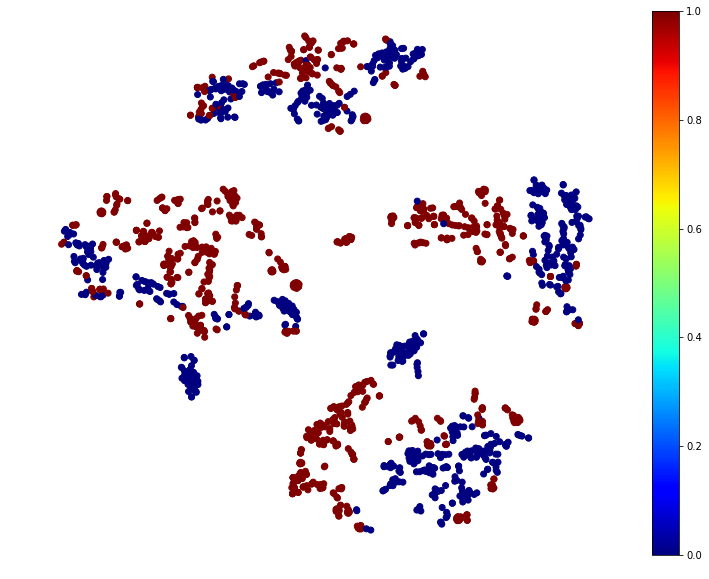

In [21]:
plt.figure(figsize=(13,10))
plt.scatter(imgs_reduced[:, 0], imgs_reduced[:, 1], c=lbls, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

In [22]:
import matplotlib
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_pieces(X, y, min_distance=0.05, num_channels = 1, images=None, figsize=(13, 10)):

    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = matplotlib.cm.get_cmap("jet")
    digits = np.unique(y)
    for l in {0, 1}:
        plt.scatter(X[y == l, 0], X[y == l, 1], c=cmap(l/2))
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            image = images[index].reshape((*IMAGE_SIZE, num_channels))
            imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
            ax.add_artist(imagebox)

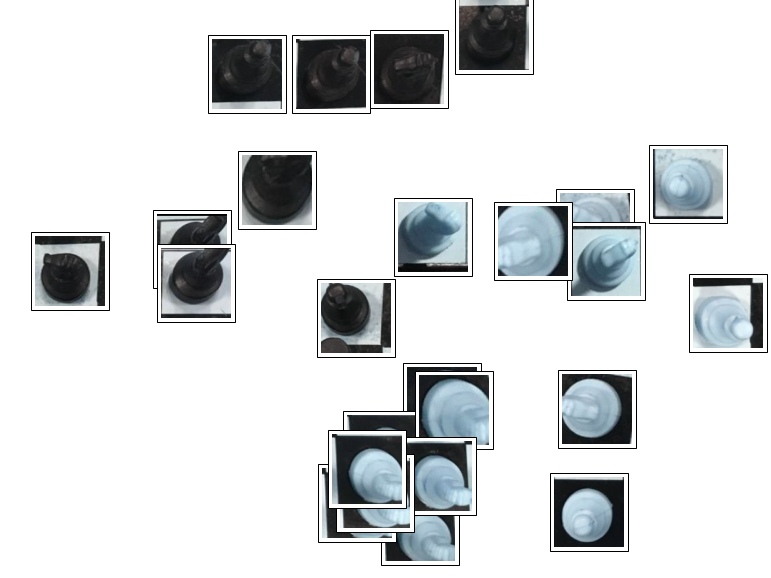

In [23]:
plot_pieces(imgs_reduced[:25], lbls[:25], min_distance=0.05, num_channels = 3, images=imgs[:25], figsize=(13, 10))

## Check how image distribution for p/n differs from n/k

n is allocated 0
k is allocated 1


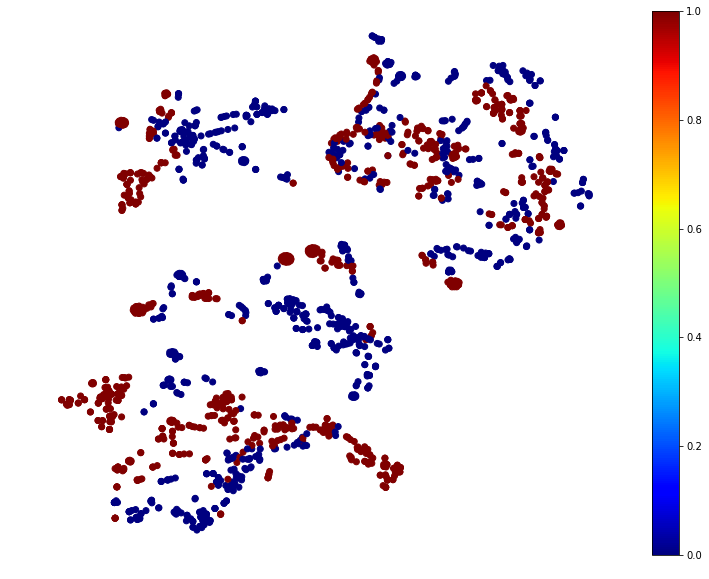

In [24]:
imgs, lbls = get_merged_images_with_labels(["n", "k"], 900, 3)
tsne = TSNE(n_components=2, random_state=42)
imgs_reduced = tsne.fit_transform(imgs)

plt.figure(figsize=(13,10))
plt.scatter(imgs_reduced[:, 0], imgs_reduced[:, 1], c=lbls, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

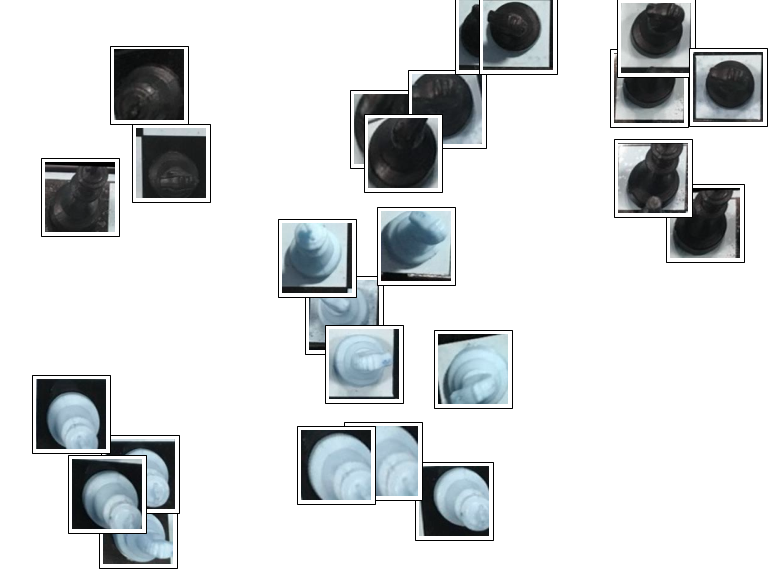

In [25]:
plot_pieces(imgs_reduced[:25], lbls[:25], min_distance=0.05, num_channels = 3, images=imgs[:25], figsize=(13, 10))